In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

In [26]:
# import
import numpy as np
import seaborn as sns # iris 데이터
import pandas as pd   # 원핫인코딩
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자 -> 숫자)
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
   # 학습과정 시각화

- iris 데이터
1. sepal_lenth : 꽃받침 길이
2. sepal_width : 꽃받침 넓이
3. petal_lenth : 꽃잎 길이
4. patal_width : 꽃잎 넓이
5. species의 종류 : 

In [8]:
# 문자 변수의 원핫인코딩 방밥 1
iris = sns.load_dataset('iris')
# to_categorical(iris['species'])
ladelEncoder = LabelEncoder()
# ladelEncoder.fit(iris['species'])
# iris['y'] = ladelEncoder.transform(iris['species'])
iris['y'] = ladelEncoder.fit_transform(iris.species)
# iris.iloc[::25]
to_categorical(iris['y'])[::25]  # to_categorical의 결과는 numpy배열

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [10]:
# 문자변수 원핫인코딩 방법2
iris = sns.load_dataset('iris')
pd.get_dummies(iris.species).values # pd.get_dummies결과는 데이터 프레임
pd.get_dummies(iris.species).to_numpy()[::25]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [22]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() # 결측치있으면 결측치 처리
# iris['species'].value_counts()  # 타겟변수의 분포

# 독립변수와 타켓변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:,-1]
iris_Y = pd.get_dummies(iris_y).values
# iris_Y[::25]

# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                    train_size= 0.8,  # 훈련셋 비율
                                                   #test_size=0.2, # 테스트 비율
                                                   #stratify=iris_Y, # 층화추출
                                                   #random_state=7, # 랜덤시드값
                                                   )
print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [33]:
# 층화추출이 되었는지 확인
iris_Y.argmax(axis=1)
print(pd.Series(np.argmax(iris_Y, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_train, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_test, axis=1)).value_counts())

0    50
1    50
2    50
dtype: int64
2    43
1    39
0    38
dtype: int64
0    12
1    11
2     7
dtype: int64


In [74]:
# 2. 모델구성(입력4, 출력3)
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=30,  activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3,  activation='softmax')) # 출력층
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                320       
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 50)                6450      
                                                                 
 dropout_16 (Dropout)        (None, 50)                0         
                                                                 
 dense_33 (Dense)            (None, 30)                1530      
                                                                 
 dropout_17 (Dropout)        (None, 30)               

In [75]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# 4. 학습 : epoch마다 val_accuracy값이 좋아지고 있으면 model 자동 저장(콜백추가)
    # 모델 자동 저장될 경로 : ./model/iris-002-val0.8745.h5
import os
model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder):  # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
# 모델 자동 저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file,
                            monitor='val_accuracy', # 모니터할 지표(기본값:val_loss)
                            mode='max',
                             save_best_only=True, # False : 매번 저장
                            verbose=1, # 모델 저장시 로그 출력 (0:로그출력 안함)
                            )
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor기본값은 val_loss
hist = model.fit(X_train, Y_train,
                #batch_size=40,
                epochs=500,
                validation_split=0.2, # 훈련셋의 20%를 검증셋
                callbacks=[earlyStopping, checkpoint])

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 1.1323 - accuracy: 0.2812
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to ./model_iris\iris-001-val0.3333.h5
3/3 [==============================] - 1s 112ms/step - loss: 1.1187 - accuracy: 0.3646 - val_loss: 1.0385 - val_accuracy: 0.3333
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0779 - accuracy: 0.3125
Epoch 2: val_accuracy improved from 0.33333 to 0.62500, saving model to ./model_iris\iris-002-val0.6250.h5
3/3 [==============================] - 0s 29ms/step - loss: 1.0625 - accuracy: 0.3958 - val_loss: 0.9887 - val_accuracy: 0.6250
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.9921 - accuracy: 0.3750
Epoch 3: val_accuracy did not improve from 0.62500
3/3 [==============================] - 0s 18ms/step - loss: 0.9871 - accuracy: 0.4479 - val_loss: 0.9276 - val_accuracy: 0.6250
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.8845 

Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1168 - accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.1868 - accuracy: 0.9479 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3060 - accuracy: 0.8750
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.2705 - accuracy: 0.9062 - val_loss: 0.1106 - val_accuracy: 1.0000
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2092 - accuracy: 0.9375
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.2301 - accuracy: 0.9062 - val_loss: 0.0988 - val_accuracy: 1.0000
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1319 - accuracy: 0.9688
Epoch 33: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 60/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1034 - accuracy: 0.9375
Epoch 60: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0803 - accuracy: 0.9688 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - accuracy: 1.0000
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.1076 - accuracy: 0.9583 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0734 - accuracy: 0.9688 - val_loss: 0.0623 - val_accuracy: 1.0000
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1132 - accuracy: 0.9688
Epoch 63: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 90/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0379 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0563 - accuracy: 0.9688 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 91/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9688
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0778 - accuracy: 0.9688 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 92/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9688
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0595 - accuracy: 0.9688 - val_loss: 0.0752 - val_accuracy: 0.9583
Epoch 93/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1337 - accuracy: 0.9688
Epoch 93: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 120/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - accuracy: 1.0000
Epoch 120: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0676 - accuracy: 0.9688 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 121/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0744 - accuracy: 0.9688
Epoch 121: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0577 - accuracy: 0.9688 - val_loss: 0.0345 - val_accuracy: 1.0000
Epoch 122/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0625 - accuracy: 0.9688
Epoch 122: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0708 - accuracy: 0.9688 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 123/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - accuracy: 1.0000
Epoch 123: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 150/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - accuracy: 1.0000
Epoch 150: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0374 - accuracy: 0.9896 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 151/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - accuracy: 1.0000
Epoch 151: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0572 - accuracy: 0.9792 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 152/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - accuracy: 0.9688
Epoch 152: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 19ms/step - loss: 0.0308 - accuracy: 0.9896 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 153/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000
Epoch 153: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 180/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 180: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 18ms/step - loss: 0.0545 - accuracy: 0.9792 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 181/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - accuracy: 1.0000
Epoch 181: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.0825 - val_accuracy: 0.9583
Epoch 182/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0983 - accuracy: 0.9688
Epoch 182: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0764 - accuracy: 0.9792 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 183/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9688
Epoch 183: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 210/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 210: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0538 - accuracy: 0.9792 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 211/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0711 - accuracy: 0.9375
Epoch 211: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0377 - accuracy: 0.9688 - val_loss: 0.0435 - val_accuracy: 0.9583
Epoch 212/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 212: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0275 - accuracy: 0.9896 - val_loss: 0.0298 - val_accuracy: 1.0000
Epoch 213/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - accuracy: 1.0000
Epoch 213: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 240/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 240: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 241/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 241: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 242/500
1/3 [=========>....................] - ETA: 0s - loss: 7.6488e-04 - accuracy: 1.0000
Epoch 242: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 243/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - accuracy: 1.0000
Epoch 243: val_accuracy did not improve from 1.00000
3/3 [===============

Epoch 270/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1424 - accuracy: 0.9375
Epoch 270: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0528 - accuracy: 0.9792 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 271/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9688
Epoch 271: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 16ms/step - loss: 0.0257 - accuracy: 0.9896 - val_loss: 0.0758 - val_accuracy: 0.9583
Epoch 272/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - accuracy: 1.0000
Epoch 272: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 17ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 273/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 273: val_accuracy did not improve from 1.00000
3/3 [===================

In [ ]:
# 5. 모델 시각화

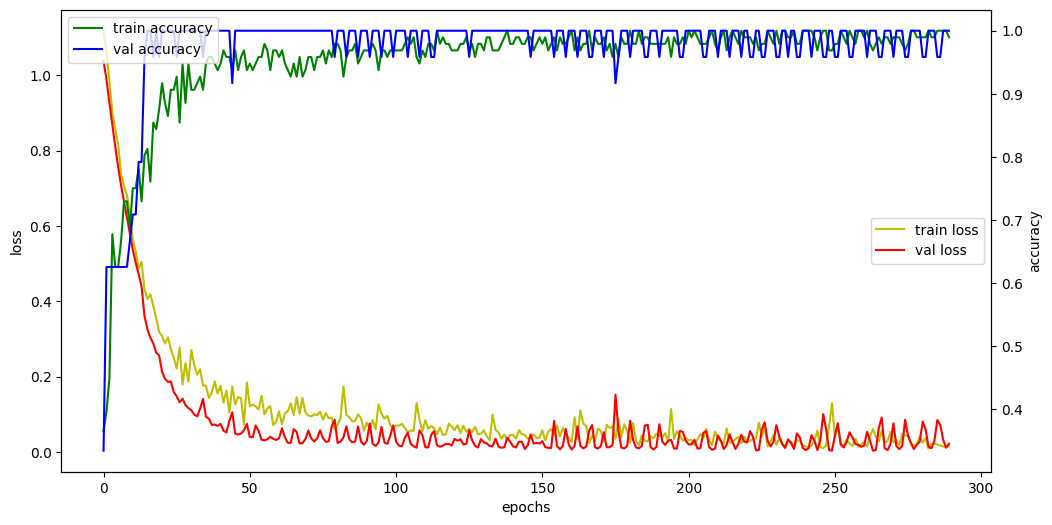

In [76]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [82]:
# 6. 모델 평가(evaluate : 테스트셋 / 교차, recall, precision : y실제값, y예측값)
# iris-065-val1.0000.h5 모델도 같이 평가
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
#학습된 모델
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
loss, acc
# 모델의 recall과 precision을 위해서 길제값과 예측값
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
recall_s = recall_score(real, pred, average='weighted') # average='weighted' : 다중분류
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model loss :', loss)
print('model accuracy : ', acc)
print('model recall : ', recall_s)
print('model precision : ', precision)
print('model f1 score : ', f1)

model loss : 0.2154517024755478
model accuracy :  0.9666666388511658
model recall :  0.9666666666666667
model precision :  0.9708333333333333
model f1 score :  0.9669841269841268


In [80]:
# 교차표
pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
pd.crosstab(real, pred,
           rownames=['real'],
           colnames=['pred'])

pred,0,1,2
real,,,
0,12,0,0
1,0,10,1
2,0,0,7


In [81]:
confusion_matrix(real, pred)

array([[12,  0,  0],
       [ 0, 10,  1],
       [ 0,  0,  7]], dtype=int64)

In [73]:
# 저장된 모델의 평가
model2 = load_model('model_iris/iris-065-val1.0000.h5')
loss, acc = model2.evaluate(X_test, Y_test)
pred = model2.predict(X_test).argmax(axis=1)
recall = recall_score(real, pred, average='weighted')
precision = precision_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')
print('model2 loss :', loss)
print('model2 acc :', acc)
print('model2 recall :', recall)
print('model2 precision :', precision)
print('model2 f1 :', f1)

1/1 [==============================] - 0s 65ms/step
model2 loss : 0.25175151228904724
model2 acc : 0.9666666388511658
model2 recall : 0.9666666666666667
model2 precision : 0.9708333333333333
model2 f1 : 0.9669841269841268


In [83]:
# 모델 저장 및 사용
save_model(model, 'model/iris.h5')
model.save('model/iris.h5') # tensorflow 2.18 이상일 경우 확장자를 .keras로도 사용할 수 

In [88]:
# 모델 예측하기
# iris.loc[100] (6.3, 3.3, 6.0, 2.5) 예측하기
result = model.predict([[6.3, 3.3, 6.0, 2.5]])
np.argmax(result)  # Virginica로 예측

1/1 [==============================] - 0s 42ms/step


2